/var/folders/fd/sjwsgyf54kb5m8t323fr7qsh0000gn/T/ipykernel_73026/1702697790.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


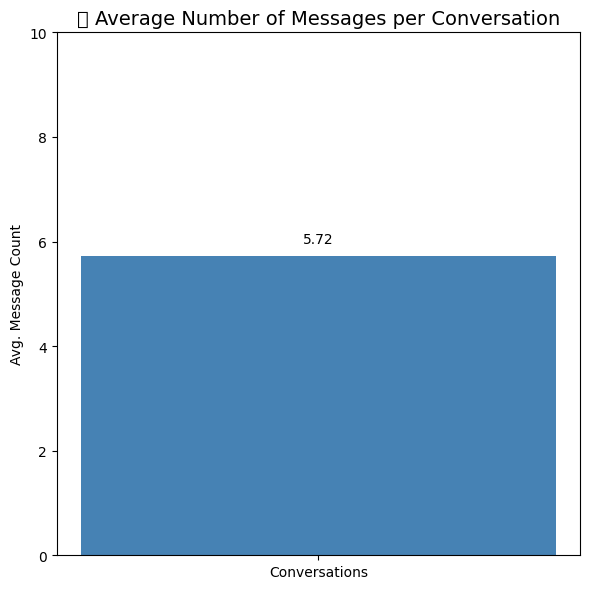

In [2]:
import json
import matplotlib.pyplot as plt

with open("gulf_chats_merged_all.json", "r", encoding="utf-8") as f:
    data = json.load(f)

num_conversations = len(data)
total_messages = sum(len(chat["messages"]) for chat in data)
avg_messages = total_messages / num_conversations

plt.figure(figsize=(6, 6))
bars = plt.bar(["Conversations"], [avg_messages], color='steelblue')
plt.title("📊 Average Number of Messages per Conversation", fontsize=14)
plt.ylabel("Avg. Message Count")
plt.ylim(0, max(10, avg_messages + 2))  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


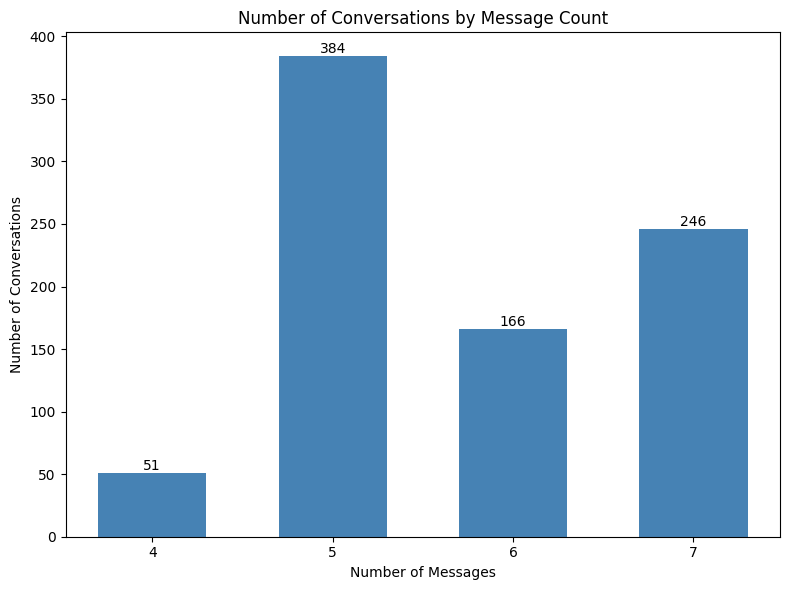

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("gulf_chats_merged_all.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

df['message_count'] = df['messages'].apply(len)

message_dist = df['message_count'].value_counts().sort_index()

filtered_dist = message_dist[(message_dist.index >= 4) & (message_dist.index <= 7)]

plt.figure(figsize=(8, 6))
bars = plt.bar(filtered_dist.index.astype(str), filtered_dist.values, color='steelblue', width=0.6)
plt.title("Number of Conversations by Message Count", fontsize=12)
plt.xlabel("Number of Messages")
plt.ylabel("Number of Conversations")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


===== Chat Data Summary =====
Total conversations: 847
Average messages per conversation: 5.72
Average words per conversation: 60.17
Max messages in a conversation: 7
Max words in a conversation: 136

Successfully loaded data from gulf_chats_merged_all.json
Saved figure to chat_analysis_results/message_count_dist_4-7.png
Saved figure to chat_analysis_results/word_count_dist_bin20_max100.png


/Users/mahmoud/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved figure to chat_analysis_results/avg_message_length_dist.png
Saved figure to chat_analysis_results/word_frequency_top15_min4.png
Generating summary report...


/Users/mahmoud/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved summary report to chat_analysis_results/summary_report_20250507_192403.png
Analysis completed successfully!


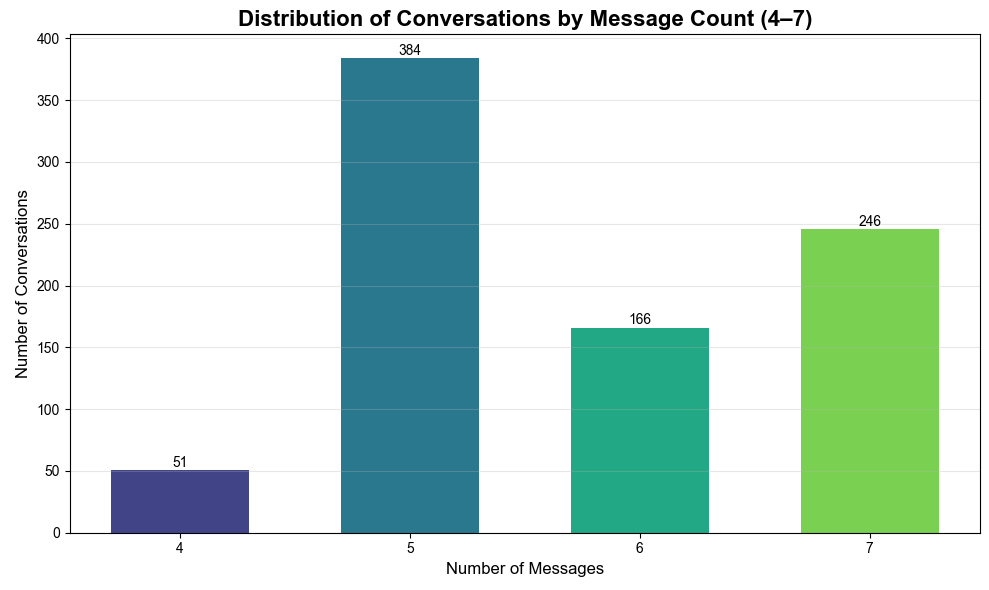

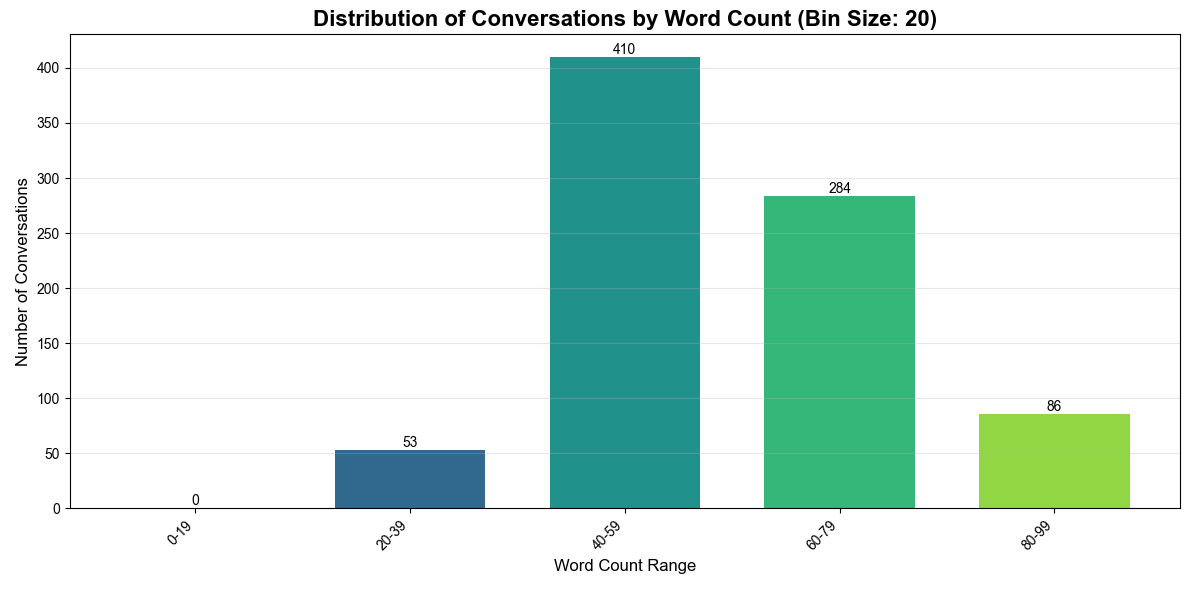

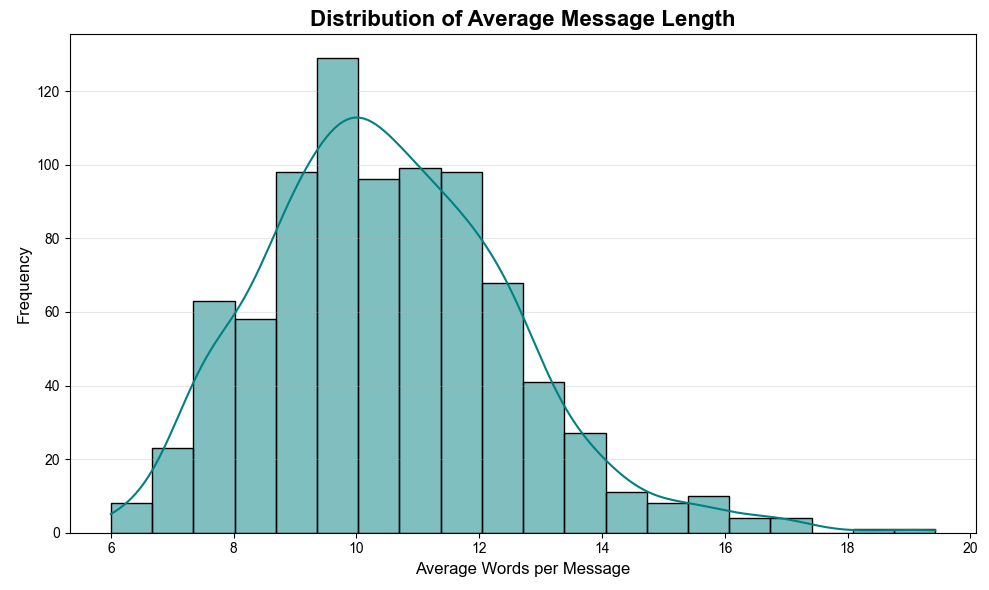

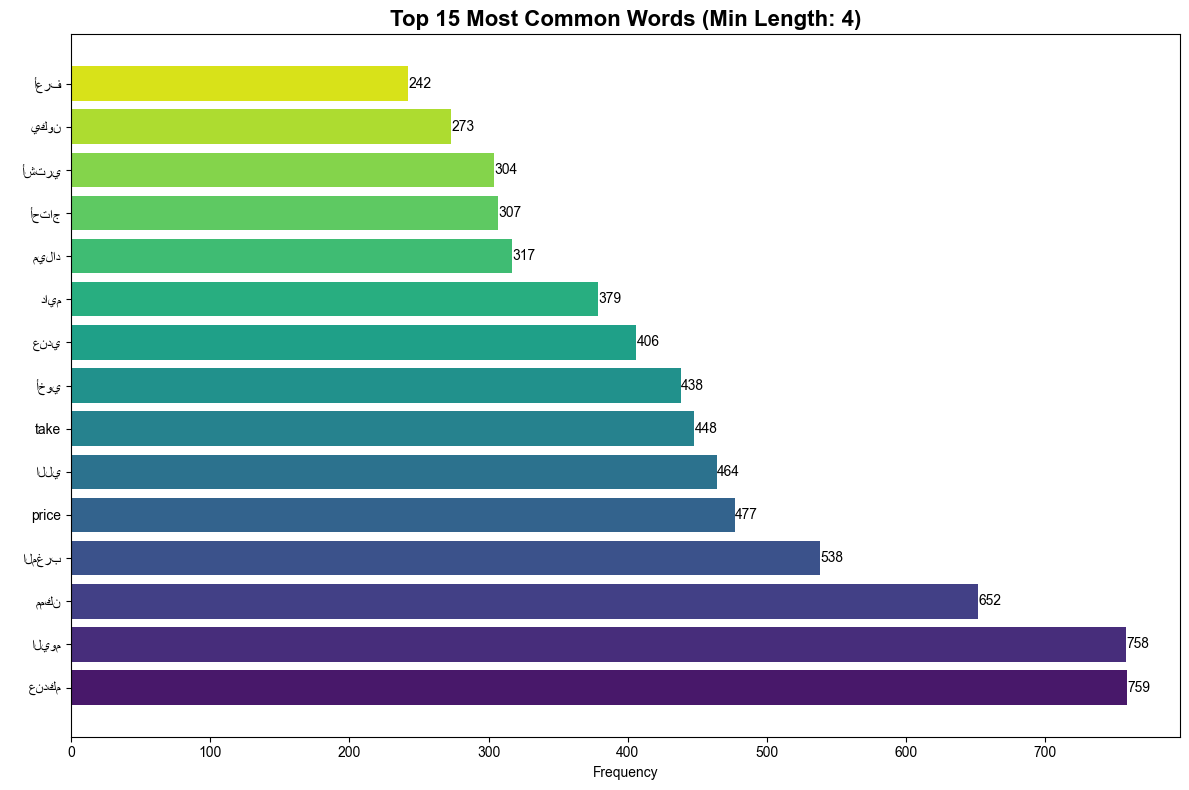

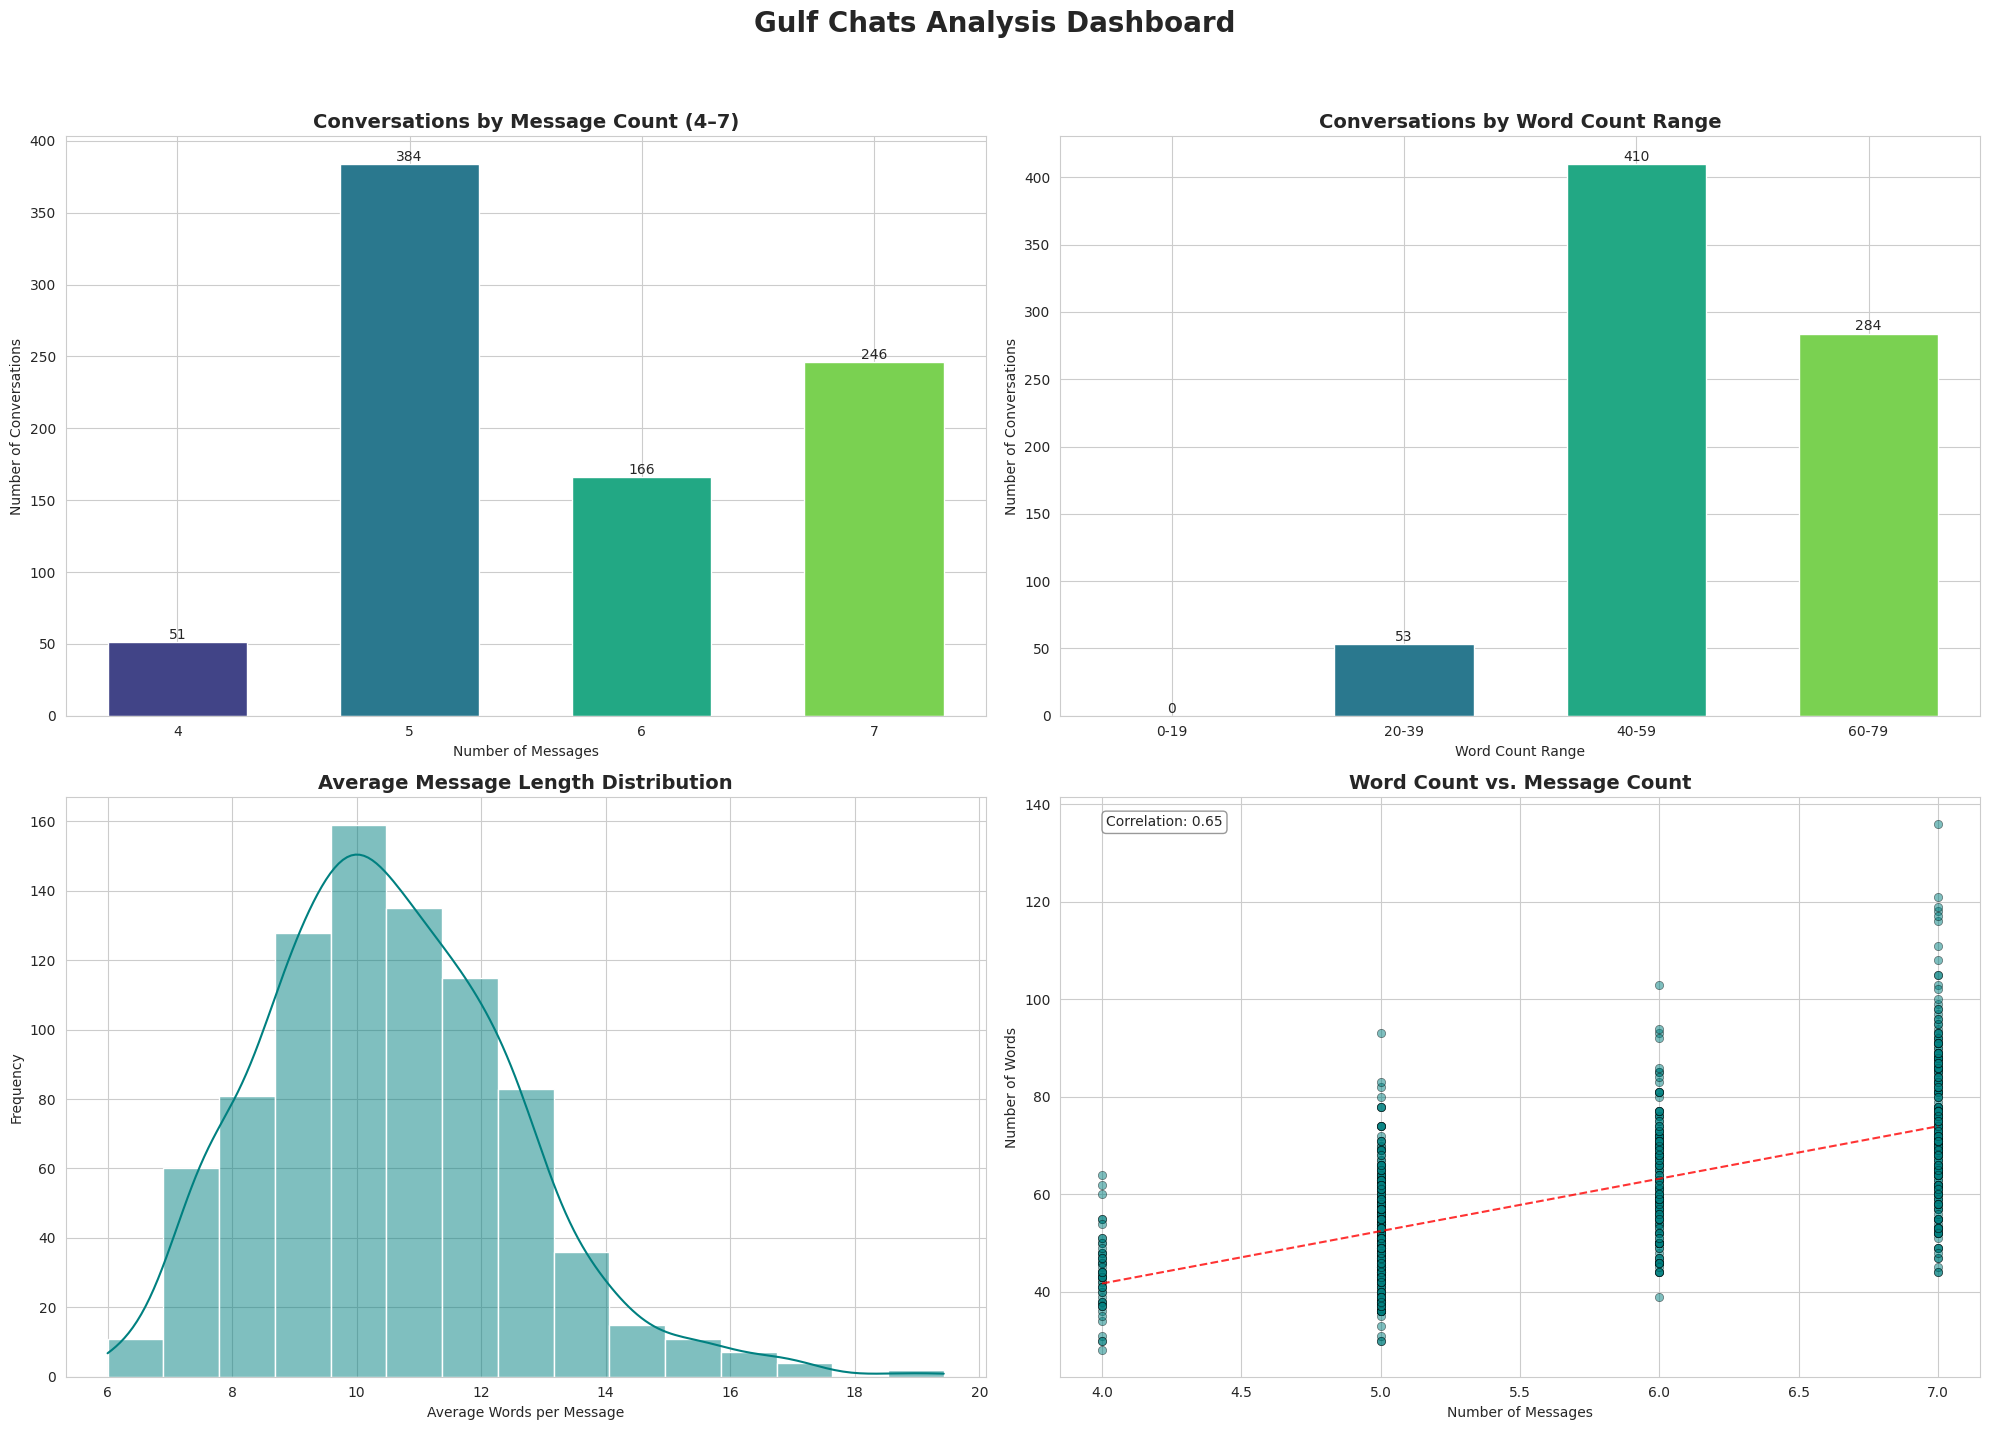

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import re
import numpy as np
from datetime import datetime


class ChatAnalyzer:
    """
    A class to analyze chat conversations data.
    """
    
    def __init__(self, file_path=None, data=None):
        """
        Initialize the ChatAnalyzer with either a file path or data.
        
        Args:
            file_path (str, optional): Path to the JSON file containing chat data.
            data (list, optional): List of chat data dictionaries.
        """
        self.df = None
        self.output_dir = "chat_analysis_results"
        
        # Create output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            
        if file_path:
            self.load_data_from_file(file_path)
        elif data:
            self.load_data(data)
    
    def load_data_from_file(self, file_path):
        """
        Load chat data from a JSON file.
        
        Args:
            file_path (str): Path to the JSON file.
            
        Returns:
            bool: True if data was loaded successfully, False otherwise.
        """
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            self.load_data(data)
            print(f"Successfully loaded data from {file_path}")
            return True
        except FileNotFoundError:
            print(f"Error: File {file_path} not found")
            return False
        except json.JSONDecodeError:
            print(f"Error: Invalid JSON format in {file_path}")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False
    
    def load_data(self, data):
        """
        Process loaded chat data into a DataFrame.
        
        Args:
            data (list): List of chat data dictionaries.
        """
        try:
            # Convert to DataFrame
            self.df = pd.DataFrame(data)
            
            # Calculate basic metrics
            self._calculate_basic_metrics()
            
            # Print data summary
            self._print_data_summary()
            
            return True
        except Exception as e:
            print(f"Error processing data: {str(e)}")
            return False
    
    def _calculate_basic_metrics(self):
        """Calculate basic metrics for the chat data."""
        # Number of messages per conversation
        self.df['message_count'] = self.df['messages'].apply(len)
        
        # Combine all messages into one text per conversation
        self.df['conversation_text'] = self.df['messages'].apply(lambda msgs: ' '.join(msg for msg in msgs if isinstance(msg, str)))
        
        # Calculate word count (more efficiently by splitting only once)
        self.df['word_count'] = self.df['conversation_text'].apply(lambda text: len(text.split()))
        
        # Calculate average message length
        self.df['avg_message_length'] = self.df.apply(
            lambda row: row['word_count'] / row['message_count'] if row['message_count'] > 0 else 0, 
            axis=1
        )
    
    def _print_data_summary(self):
        """Print a summary of the loaded data."""
        print("\n===== Chat Data Summary =====")
        print(f"Total conversations: {len(self.df)}")
        print(f"Average messages per conversation: {self.df['message_count'].mean():.2f}")
        print(f"Average words per conversation: {self.df['word_count'].mean():.2f}")
        print(f"Max messages in a conversation: {self.df['message_count'].max()}")
        print(f"Max words in a conversation: {self.df['word_count'].max()}")
        print("============================\n")
    
    def plot_message_count_distribution(self, min_count=None, max_count=None, save=True):
        """
        Plot the distribution of message counts.
        
        Args:
            min_count (int, optional): Minimum message count to include.
            max_count (int, optional): Maximum message count to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Filter data if min/max provided
        filtered_df = self.df.copy()
        if min_count is not None:
            filtered_df = filtered_df[filtered_df['message_count'] >= min_count]
        if max_count is not None:
            filtered_df = filtered_df[filtered_df['message_count'] <= max_count]
        
        # Calculate distribution
        message_dist = filtered_df['message_count'].value_counts().sort_index()
        
        # Create plot
        plt.figure(figsize=(10, 6))
        
        # Use a color palette
        color_palette = sns.color_palette("viridis", len(message_dist))
        
        bars = plt.bar(message_dist.index.astype(str), message_dist.values, 
                       color=color_palette, width=0.6)
        
        # Title with filtering information
        filter_info = ""
        if min_count is not None or max_count is not None:
            filter_info = " ("
            if min_count is not None:
                filter_info += f"{min_count}"
            else:
                filter_info += "min"
            
            filter_info += "–"
            
            if max_count is not None:
                filter_info += f"{max_count}"
            else:
                filter_info += "max"
                
            filter_info += ")"
        
        plt.title(f"Distribution of Conversations by Message Count{filter_info}", 
                  fontsize=16, fontweight='bold')
        plt.xlabel("Number of Messages", fontsize=12)
        plt.ylabel("Number of Conversations", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filter_str = f"{min_count or 'min'}-{max_count or 'max'}"
            filename = f"{self.output_dir}/message_count_dist_{filter_str}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def plot_word_count_distribution(self, bin_size=20, max_words=None, save=True):
        """
        Plot the distribution of word counts.
        
        Args:
            bin_size (int, optional): Size of word count bins.
            max_words (int, optional): Maximum word count to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Filter data if max_words provided
        filtered_df = self.df.copy()
        if max_words is not None:
            filtered_df = filtered_df[filtered_df['word_count'] <= max_words]
        
        # Determine the bin range based on data and parameters
        max_bin = max_words if max_words else filtered_df['word_count'].max()
        bins = range(0, max_bin + bin_size, bin_size)
        labels = [f"{b}-{b+bin_size-1}" for b in bins[:-1]]
        
        # Create bins
        filtered_df['word_bin'] = pd.cut(filtered_df['word_count'], 
                                         bins=bins, 
                                         labels=labels, 
                                         right=False,
                                         include_lowest=True)
        
        # Calculate distribution
        word_dist = filtered_df['word_bin'].value_counts().sort_index()
        
        # Create plot
        plt.figure(figsize=(12, 6))
        
        # Use a color palette
        color_palette = sns.color_palette("viridis", len(word_dist))
        
        bars = plt.bar(word_dist.index.astype(str), word_dist.values, 
                      color=color_palette, width=0.7)
        
        plt.title(f"Distribution of Conversations by Word Count (Bin Size: {bin_size})", 
                 fontsize=16, fontweight='bold')
        plt.xlabel("Word Count Range", fontsize=12)
        plt.ylabel("Number of Conversations", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            max_str = f"_max{max_words}" if max_words else ""
            filename = f"{self.output_dir}/word_count_dist_bin{bin_size}{max_str}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def plot_message_length_distribution(self, save=True):
        """
        Plot the distribution of average message lengths.
        
        Args:
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        plt.figure(figsize=(10, 6))
        
        # Create histogram with KDE
        sns.histplot(self.df['avg_message_length'], kde=True, bins=20, color='teal')
        
        plt.title("Distribution of Average Message Length", 
                 fontsize=16, fontweight='bold')
        plt.xlabel("Average Words per Message", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/avg_message_length_dist.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def analyze_word_frequency(self, top_n=20, min_length=3, save=True):
        """
        Analyze and plot the most frequent words in all conversations.
        
        Args:
            top_n (int, optional): Number of top words to display.
            min_length (int, optional): Minimum word length to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Combine all conversation texts
        all_text = ' '.join(self.df['conversation_text'])
        
        # Clean text and split into words
        words = re.findall(r'\b\w+\b', all_text.lower())
        
        # Filter words by length
        words = [word for word in words if len(word) >= min_length]
        
        # Count word frequencies
        word_counts = Counter(words)
        
        # Get top N words
        top_words = word_counts.most_common(top_n)
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        words, counts = zip(*top_words)
        y_pos = np.arange(len(words))
        
        # Create horizontal bar chart
        bars = plt.barh(y_pos, counts, align='center', 
                       color=sns.color_palette("viridis", len(words)))
        
        plt.yticks(y_pos, words)
        plt.xlabel('Frequency')
        plt.title(f'Top {top_n} Most Common Words (Min Length: {min_length})', 
                 fontsize=16, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/word_frequency_top{top_n}_min{min_length}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def create_summary_report(self):
        """
        Create a comprehensive summary report with multiple visualizations.
        """
        # Set the style
        sns.set_style("whitegrid")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        
        print("Generating summary report...")
        
        # Create a figure with subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Message count distribution (4-7)
        plt.subplot(2, 2, 1)
        message_dist = self.df['message_count'].value_counts().sort_index()
        filtered_msg_dist = message_dist[(message_dist.index >= 4) & (message_dist.index <= 7)]
        
        bars = plt.bar(filtered_msg_dist.index.astype(str), filtered_msg_dist.values, 
                      color=sns.color_palette("viridis", len(filtered_msg_dist)), width=0.6)
        
        plt.title("Conversations by Message Count (4–7)", fontsize=14, fontweight='bold')
        plt.xlabel("Number of Messages")
        plt.ylabel("Number of Conversations")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        # 2. Word count distribution
        plt.subplot(2, 2, 2)
        
        # Define word count bins
        bins = range(0, 100, 20)
        labels = [f"{b}-{b+19}" for b in bins[:-1]]
        
        self.df['word_bin'] = pd.cut(self.df['word_count'], bins=bins, labels=labels, right=False)
        word_dist = self.df['word_bin'].value_counts().sort_index()
        
        bars = plt.bar(word_dist.index.astype(str), word_dist.values, 
                      color=sns.color_palette("viridis", len(word_dist)), width=0.6)
        
        plt.title("Conversations by Word Count Range", fontsize=14, fontweight='bold')
        plt.xlabel("Word Count Range")
        plt.ylabel("Number of Conversations")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        # 3. Average message length distribution
        plt.subplot(2, 2, 3)
        sns.histplot(self.df['avg_message_length'], kde=True, bins=15, color='teal')
        plt.title("Average Message Length Distribution", fontsize=14, fontweight='bold')
        plt.xlabel("Average Words per Message")
        plt.ylabel("Frequency")
        
        # 4. Word count vs. message count scatter
        plt.subplot(2, 2, 4)
        plt.scatter(self.df['message_count'], self.df['word_count'], 
                   alpha=0.5, c='teal', edgecolors='k', linewidths=0.5)
        
        plt.title("Word Count vs. Message Count", fontsize=14, fontweight='bold')
        plt.xlabel("Number of Messages")
        plt.ylabel("Number of Words")
        
        # Add a trend line
        z = np.polyfit(self.df['message_count'], self.df['word_count'], 1)
        p = np.poly1d(z)
        plt.plot(np.unique(self.df['message_count']), 
                p(np.unique(self.df['message_count'])), 
                'r--', alpha=0.8)
        
        # Add correlation value
        corr = self.df[['message_count', 'word_count']].corr().iloc[0, 1]
        plt.annotate(f"Correlation: {corr:.2f}", 
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        # Overall title and adjustments
        plt.suptitle("Gulf Chats Analysis Dashboard", fontsize=20, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the summary report
        filename = f"{self.output_dir}/summary_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved summary report to {filename}")
        
        return fig


# Example usage
if __name__ == "__main__":
    try:
        # Initialize the analyzer with the JSON file
        analyzer = ChatAnalyzer("gulf_chats_merged_all.json")
        
        # Generate individual plots
        analyzer.plot_message_count_distribution(min_count=4, max_count=7)
        analyzer.plot_word_count_distribution(bin_size=20, max_words=100)
        analyzer.plot_message_length_distribution()
        analyzer.analyze_word_frequency(top_n=15, min_length=4)
        
        # Generate summary report
        analyzer.create_summary_report()
        
        print("Analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")


/var/folders/fd/sjwsgyf54kb5m8t323fr7qsh0000gn/T/ipykernel_73026/59395164.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/mahmoud/.pyenv/versions/3.12.5/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


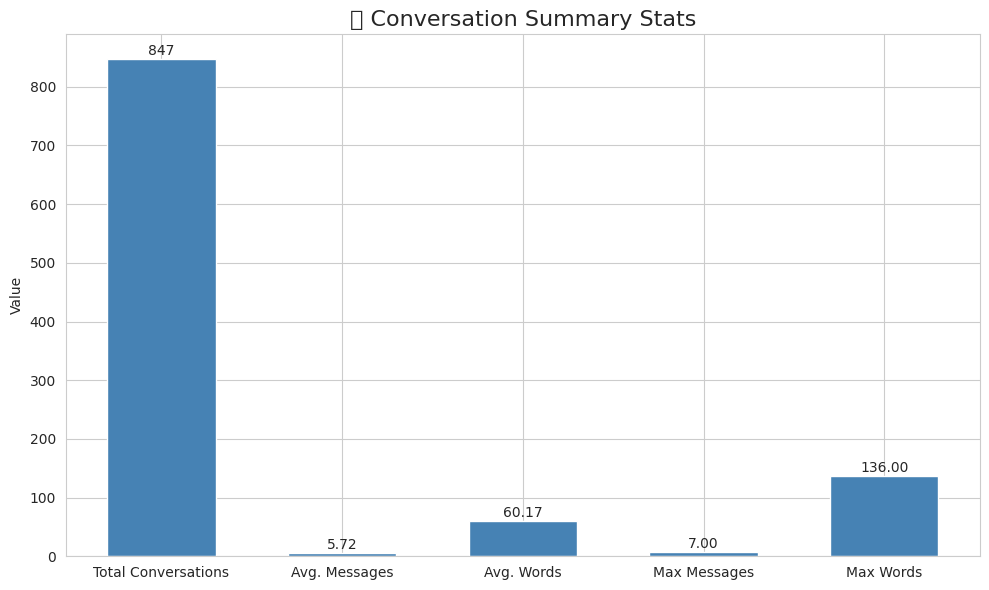

In [19]:
import matplotlib.pyplot as plt

# Stats
total_conversations = 847
avg_messages = 5.72
avg_words = 60.17
max_messages = 7
max_words = 136

# Data for plotting
labels = [
    "Total Conversations",
    "Avg. Messages",
    "Avg. Words",
    "Max Messages",
    "Max Words"
]
values = [
    total_conversations,
    avg_messages,
    avg_words,
    max_messages,
    max_words
]

# Define colors (you can customize)
colors = ['steelblue'] * len(labels)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors, width=0.6)
plt.title("📊 Conversation Summary Stats", fontsize=16)
plt.ylabel("Value")

# Annotate values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2, f'{height:.2f}' if height != total_conversations else int(height),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
